# Structure selection strategies

This notebooks compares different strategies to pick the most reasonable structure/docking result, i.e. docking score or Posit probability and 2D or 3D similarity of the molecule to dock and the co-crystallized ligand.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.utils import resample

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)

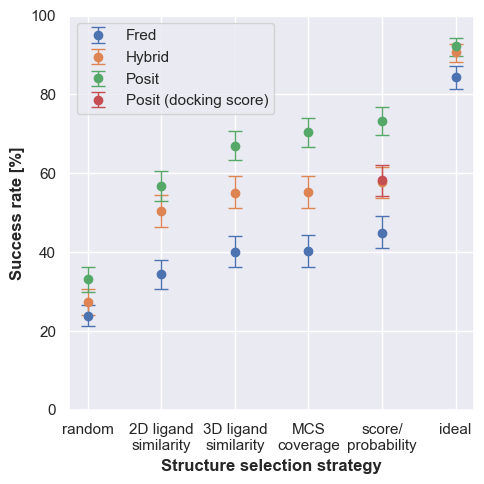

In [5]:
def plot_selection_strategies(fred_results, hybrid_results, posit_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # 1 subplot
    fig, axis = plt.subplots(1, 1, figsize=(5, 5))
    
    # sample data
    sampled_success_rates = []
    for i, (method, results) in enumerate(zip(
        ["Fred", "Hybrid", "Posit", "Posit (docking score)"], 
        [fred_results, hybrid_results, posit_results, posit_results]
    )):
        for selection_strategy in ["random", "2D ligand similarity", "3D ligand similarity", "mcs coverage", "score/probability", "ideal"]:
            if method == "Posit (docking score)" and selection_strategy != "score/probability":
                continue
            if selection_strategy == "mcs coverage":
                selected_results = results.sort_values("mcs_coverage", ascending=False)
            if selection_strategy == "2D ligand similarity":
                selected_results = results.sort_values("fingerprint_similarity", ascending=False)
            elif selection_strategy == "3D ligand similarity":
                selected_results = results.sort_values("shape_similarity", ascending=False)
            elif selection_strategy == "score/probability":
                selected_results = results.sort_values("docking_score")
                if method == "Posit":
                    selected_results = selected_results.sort_values("posit_probability", ascending=False)
            elif selection_strategy == "ideal":
                selected_results = results.sort_values("rmsd")
            if selection_strategy != "random":
                selected_results = selected_results.groupby(["ligand_pdb_id"]).head(1)
                success_labels = (selected_results["rmsd"] <= 2).to_list()
            sampled_success_rates_i = []
            for _ in range(n_bootstrap):
                if selection_strategy == "random":
                    sampled_results = results.groupby("ligand_pdb_id").sample(n=1, replace=True)
                    sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                else:
                    sampled_success_labels = resample(success_labels, replace=True)
                sampled_success_rates_i.append((sum(sampled_success_labels) / len(sampled_success_labels)) * 100)
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            cutoff = (1 - ci) / 2
            success_rate_mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
            ci_upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
            sampled_success_rates.append([
                method,
                selection_strategy,
                success_rate_mean,
                ci_lower_bound,
                ci_upper_bound
            ])
            
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, columns=["method", "selection_strategy", "success_rate", "ci_lower", "ci_upper"]
    )
    
    # plot data
    for i, method in enumerate(["Fred", "Hybrid", "Posit", "Posit (docking score)"]):
        sampled_success_rates_i = sampled_success_rates[
            sampled_success_rates["method"] == method
        ]
        axis.errorbar(
            x=sampled_success_rates_i["selection_strategy"],
            y=sampled_success_rates_i["success_rate"],
            yerr=[
                sampled_success_rates_i["success_rate"] - sampled_success_rates_i["ci_lower"], 
                sampled_success_rates_i["ci_upper"] - sampled_success_rates_i["success_rate"]
            ],
            fmt="o",
            elinewidth=1,
            capsize=5,
            capthick=1,
            label=method
        )
    axis.set_xticks(["random", "2D ligand similarity", "3D ligand similarity", "mcs coverage", "score/probability", "ideal"])
    axis.set_xticklabels(["random", "2D ligand\nsimilarity", "3D ligand\nsimilarity", "MCS\ncoverage", "score/\nprobability", "ideal"])
    axis.set_xlabel("Structure selection strategy", fontweight="bold")
    axis.set_ylabel("Success rate [%]", fontweight="bold")
    axis.set_ylim([0, 100])
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(directory / "selection_strategies.pdf", dpi=300)
    
    return sampled_success_rates


sampled_success_rates = plot_selection_strategies(fred_results, hybrid_results, posit_results)

In [6]:
sampled_success_rates

,method,selection_strategy,success_rate,ci_lower,ci_upper
0,Fred,random,23.753990,21.222411,26.655348
1,Fred,2D ligand similarity,34.358065,30.560272,38.030560
2,Fred,3D ligand similarity,39.978098,36.162988,43.972835
3,Fred,mcs coverage,40.237691,36.332767,44.312394
4,Fred,score/probability,44.928862,41.086587,49.066214
5,Fred,ideal,84.347708,81.324278,87.266553
6,Hybrid,random,27.337861,24.108659,30.560272
7,Hybrid,2D ligand similarity,50.404754,46.349745,54.499151
8,Hybrid,3D ligand similarity,55.114092,51.103565,59.252971
9,Hybrid,mcs coverage,55.155008,51.273345,59.422750
